# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

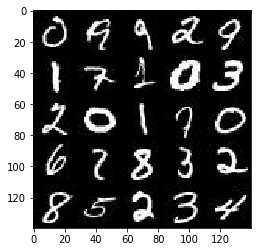

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

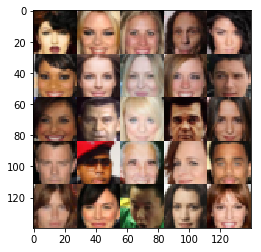

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, (None, image_width, 
                                                    image_height, 
                                                    image_channels), name='input_real')    
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.2
        
        # 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x28
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x112
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 3x3x224

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        alpha = 0.2
        
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x256 now
        
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x128 now
        
        out = tf.tanh(logits)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    #tf.reset_default_graph()
    
    class GAN:
        def __init__(self, real_size, z_size, learning_rate, alpha=0.2, beta1=0.5):
            image_width = data_shape[1]
            image_height = data_shape[2]
            image_channels = data_shape[3]
            self.input_real, self.input_z, self.learning_rate = model_inputs(image_width, 
                                                                             image_height,
                                                                             image_channels,
                                                                             z_size)
            
            self.d_loss, self.g_loss = model_loss(self.input_real, self.input_z,
                                                  real_size[3])
            
            self.d_opt, self.g_opt = model_opt(self.d_loss, self.g_loss, learning_rate, 0.5)

    net = GAN(data_shape, z_dim, learning_rate, alpha=0.2, beta1=beta1)
    
    losses = []
    samples = []
    batches = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batches += 1
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(net.d_opt, feed_dict={net.input_real: batch_images, net.input_z: batch_z})
                _ = sess.run(net.g_opt, feed_dict={net.input_z: batch_z})
                
                if batches % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = net.d_loss.eval({net.input_z: batch_z, net.input_real: batch_images})
                    train_loss_g = net.g_loss.eval({net.input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if batches % show_every == 0:
                    gen_samples = sess.run(
                                   generator(net.input_z, data_shape[3], is_train=False),
                                   feed_dict={net.input_z: batch_z})
                    samples.append(gen_samples)
                    _ = show_generator_output(sess, 16, net.input_z, data_shape[3], data_image_mode)
                    plt.show()

    with open('samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    return losses, samples

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.6998... Generator Loss: 1.0814
Epoch 1/2... Discriminator Loss: 1.0470... Generator Loss: 0.9839
Epoch 1/2... Discriminator Loss: 1.4699... Generator Loss: 0.6444
Epoch 1/2... Discriminator Loss: 0.9747... Generator Loss: 1.0000
Epoch 1/2... Discriminator Loss: 0.9436... Generator Loss: 1.2723
Epoch 1/2... Discriminator Loss: 1.0589... Generator Loss: 1.4651
Epoch 1/2... Discriminator Loss: 0.9155... Generator Loss: 1.4795
Epoch 1/2... Discriminator Loss: 1.1797... Generator Loss: 0.5372
Epoch 1/2... Discriminator Loss: 0.8871... Generator Loss: 0.8805
Epoch 1/2... Discriminator Loss: 0.6740... Generator Loss: 1.2294


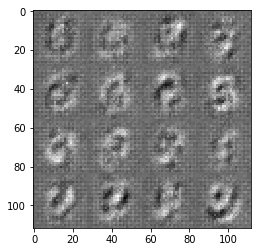

Epoch 1/2... Discriminator Loss: 0.8728... Generator Loss: 0.7004
Epoch 1/2... Discriminator Loss: 0.5423... Generator Loss: 1.9820
Epoch 1/2... Discriminator Loss: 0.5221... Generator Loss: 1.3366
Epoch 1/2... Discriminator Loss: 0.5187... Generator Loss: 1.1911
Epoch 1/2... Discriminator Loss: 0.5383... Generator Loss: 3.4926
Epoch 1/2... Discriminator Loss: 0.5248... Generator Loss: 1.0689
Epoch 1/2... Discriminator Loss: 0.1865... Generator Loss: 2.8701
Epoch 1/2... Discriminator Loss: 0.4220... Generator Loss: 1.3480
Epoch 1/2... Discriminator Loss: 0.2122... Generator Loss: 3.0194
Epoch 1/2... Discriminator Loss: 0.1624... Generator Loss: 3.8234


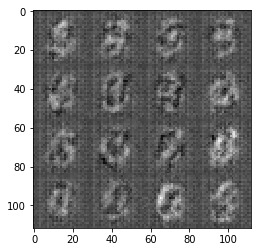

Epoch 1/2... Discriminator Loss: 2.1476... Generator Loss: 0.1464
Epoch 1/2... Discriminator Loss: 0.2820... Generator Loss: 1.8660
Epoch 1/2... Discriminator Loss: 0.3641... Generator Loss: 1.5970
Epoch 2/2... Discriminator Loss: 0.1406... Generator Loss: 3.6504
Epoch 2/2... Discriminator Loss: 0.3455... Generator Loss: 2.3701
Epoch 2/2... Discriminator Loss: 1.4835... Generator Loss: 5.3906
Epoch 2/2... Discriminator Loss: 0.2747... Generator Loss: 2.2531
Epoch 2/2... Discriminator Loss: 0.2496... Generator Loss: 2.2016
Epoch 2/2... Discriminator Loss: 0.2338... Generator Loss: 2.9855
Epoch 2/2... Discriminator Loss: 0.2571... Generator Loss: 2.0650


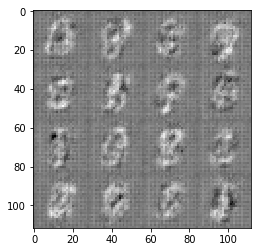

Epoch 2/2... Discriminator Loss: 0.2448... Generator Loss: 2.7496
Epoch 2/2... Discriminator Loss: 0.2024... Generator Loss: 2.6453
Epoch 2/2... Discriminator Loss: 0.7670... Generator Loss: 0.8638
Epoch 2/2... Discriminator Loss: 0.3228... Generator Loss: 1.8867
Epoch 2/2... Discriminator Loss: 0.2249... Generator Loss: 2.3380
Epoch 2/2... Discriminator Loss: 0.2331... Generator Loss: 2.3770
Epoch 2/2... Discriminator Loss: 0.2454... Generator Loss: 2.5531
Epoch 2/2... Discriminator Loss: 0.2150... Generator Loss: 2.8159
Epoch 2/2... Discriminator Loss: 0.2084... Generator Loss: 2.3892
Epoch 2/2... Discriminator Loss: 0.2357... Generator Loss: 2.1621


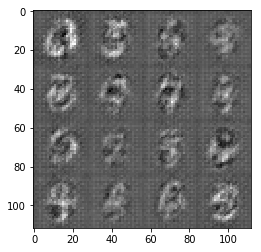

Epoch 2/2... Discriminator Loss: 0.9115... Generator Loss: 5.3899
Epoch 2/2... Discriminator Loss: 0.1909... Generator Loss: 2.6882
Epoch 2/2... Discriminator Loss: 0.2182... Generator Loss: 2.2889
Epoch 2/2... Discriminator Loss: 0.2375... Generator Loss: 2.8662
Epoch 2/2... Discriminator Loss: 0.1795... Generator Loss: 2.6769
Epoch 2/2... Discriminator Loss: 0.1781... Generator Loss: 2.7407


In [12]:
batch_size = 256
z_dim = 100
learning_rate = .0001
beta1 = .5
print_every = 10
show_every = 100

import matplotlib.pyplot as plt
import pickle as pkl

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.2444... Generator Loss: 0.6275
Epoch 1/1... Discriminator Loss: 1.3229... Generator Loss: 0.7701
Epoch 1/1... Discriminator Loss: 0.7720... Generator Loss: 1.1927
Epoch 1/1... Discriminator Loss: 0.7461... Generator Loss: 1.1323
Epoch 1/1... Discriminator Loss: 0.5971... Generator Loss: 1.6733
Epoch 1/1... Discriminator Loss: 0.6861... Generator Loss: 0.9911
Epoch 1/1... Discriminator Loss: 0.7579... Generator Loss: 1.3385
Epoch 1/1... Discriminator Loss: 0.5910... Generator Loss: 1.9147
Epoch 1/1... Discriminator Loss: 0.5454... Generator Loss: 1.4430
Epoch 1/1... Discriminator Loss: 0.3942... Generator Loss: 2.1899


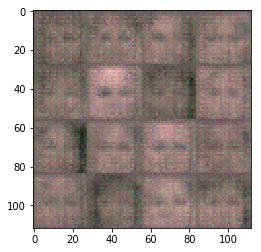

Epoch 1/1... Discriminator Loss: 0.3061... Generator Loss: 3.2255
Epoch 1/1... Discriminator Loss: 0.2821... Generator Loss: 3.1545
Epoch 1/1... Discriminator Loss: 0.2290... Generator Loss: 2.5046
Epoch 1/1... Discriminator Loss: 0.2627... Generator Loss: 2.0435
Epoch 1/1... Discriminator Loss: 0.1624... Generator Loss: 3.0135
Epoch 1/1... Discriminator Loss: 0.6466... Generator Loss: 0.9237
Epoch 1/1... Discriminator Loss: 0.1176... Generator Loss: 3.2781
Epoch 1/1... Discriminator Loss: 0.2849... Generator Loss: 4.9207
Epoch 1/1... Discriminator Loss: 1.3532... Generator Loss: 0.4014
Epoch 1/1... Discriminator Loss: 0.5660... Generator Loss: 4.9585


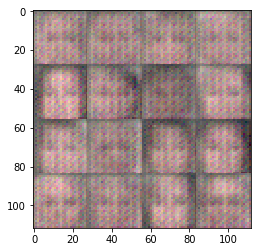

Epoch 1/1... Discriminator Loss: 1.4169... Generator Loss: 6.9252
Epoch 1/1... Discriminator Loss: 0.1894... Generator Loss: 3.1558
Epoch 1/1... Discriminator Loss: 2.4982... Generator Loss: 0.1364
Epoch 1/1... Discriminator Loss: 1.5728... Generator Loss: 0.7334
Epoch 1/1... Discriminator Loss: 1.5722... Generator Loss: 0.5495
Epoch 1/1... Discriminator Loss: 1.2081... Generator Loss: 0.7608
Epoch 1/1... Discriminator Loss: 0.9920... Generator Loss: 0.9220
Epoch 1/1... Discriminator Loss: 1.0880... Generator Loss: 0.8997
Epoch 1/1... Discriminator Loss: 1.1094... Generator Loss: 0.8793
Epoch 1/1... Discriminator Loss: 1.2116... Generator Loss: 0.8266


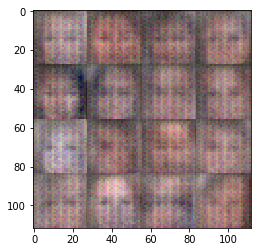

Epoch 1/1... Discriminator Loss: 1.0576... Generator Loss: 0.8512
Epoch 1/1... Discriminator Loss: 1.0737... Generator Loss: 0.7336
Epoch 1/1... Discriminator Loss: 0.9345... Generator Loss: 0.9321
Epoch 1/1... Discriminator Loss: 0.9554... Generator Loss: 0.9150
Epoch 1/1... Discriminator Loss: 1.2121... Generator Loss: 0.5903
Epoch 1/1... Discriminator Loss: 0.9872... Generator Loss: 0.9247
Epoch 1/1... Discriminator Loss: 0.7658... Generator Loss: 1.0113
Epoch 1/1... Discriminator Loss: 0.8342... Generator Loss: 1.1086
Epoch 1/1... Discriminator Loss: 1.0041... Generator Loss: 1.0314
Epoch 1/1... Discriminator Loss: 0.9003... Generator Loss: 1.1272


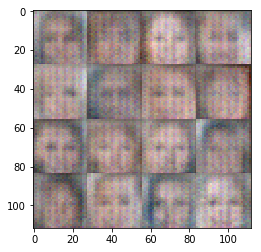

Epoch 1/1... Discriminator Loss: 0.9483... Generator Loss: 1.3523
Epoch 1/1... Discriminator Loss: 0.9368... Generator Loss: 0.8329
Epoch 1/1... Discriminator Loss: 0.7919... Generator Loss: 0.9860
Epoch 1/1... Discriminator Loss: 0.7906... Generator Loss: 0.8842
Epoch 1/1... Discriminator Loss: 0.7688... Generator Loss: 1.2290
Epoch 1/1... Discriminator Loss: 0.6903... Generator Loss: 1.2243
Epoch 1/1... Discriminator Loss: 0.2358... Generator Loss: 2.5501
Epoch 1/1... Discriminator Loss: 0.7864... Generator Loss: 0.8016
Epoch 1/1... Discriminator Loss: 0.5953... Generator Loss: 1.0059
Epoch 1/1... Discriminator Loss: 0.3812... Generator Loss: 1.4721


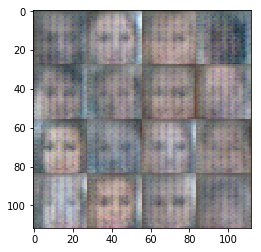

Epoch 1/1... Discriminator Loss: 0.9911... Generator Loss: 0.5962
Epoch 1/1... Discriminator Loss: 0.4640... Generator Loss: 1.3240
Epoch 1/1... Discriminator Loss: 0.1697... Generator Loss: 12.0249
Epoch 1/1... Discriminator Loss: 0.1296... Generator Loss: 3.5680
Epoch 1/1... Discriminator Loss: 1.6122... Generator Loss: 4.8777
Epoch 1/1... Discriminator Loss: 1.5381... Generator Loss: 8.8484
Epoch 1/1... Discriminator Loss: 0.2417... Generator Loss: 2.7866
Epoch 1/1... Discriminator Loss: 0.9330... Generator Loss: 13.2408
Epoch 1/1... Discriminator Loss: 0.0974... Generator Loss: 4.2200
Epoch 1/1... Discriminator Loss: 0.6486... Generator Loss: 2.3378


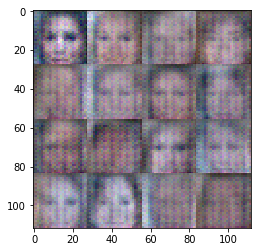

Epoch 1/1... Discriminator Loss: 1.0785... Generator Loss: 4.8555
Epoch 1/1... Discriminator Loss: 0.7084... Generator Loss: 13.4652
Epoch 1/1... Discriminator Loss: 0.1325... Generator Loss: 6.1941
Epoch 1/1... Discriminator Loss: 0.4959... Generator Loss: 1.4819
Epoch 1/1... Discriminator Loss: 0.0745... Generator Loss: 7.7842
Epoch 1/1... Discriminator Loss: 0.4273... Generator Loss: 5.4126
Epoch 1/1... Discriminator Loss: 0.0427... Generator Loss: 11.0036
Epoch 1/1... Discriminator Loss: 0.2912... Generator Loss: 6.0162
Epoch 1/1... Discriminator Loss: 0.4013... Generator Loss: 4.3669
Epoch 1/1... Discriminator Loss: 0.0500... Generator Loss: 5.2430


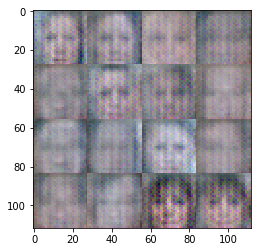

Epoch 1/1... Discriminator Loss: 0.1724... Generator Loss: 8.1554
Epoch 1/1... Discriminator Loss: 0.0999... Generator Loss: 6.5302
Epoch 1/1... Discriminator Loss: 0.2221... Generator Loss: 8.2467
Epoch 1/1... Discriminator Loss: 0.2267... Generator Loss: 1.8378
Epoch 1/1... Discriminator Loss: 0.1232... Generator Loss: 3.9446
Epoch 1/1... Discriminator Loss: 0.0616... Generator Loss: 12.1987
Epoch 1/1... Discriminator Loss: 0.3683... Generator Loss: 1.5366
Epoch 1/1... Discriminator Loss: 0.1533... Generator Loss: 4.8824
Epoch 1/1... Discriminator Loss: 0.0252... Generator Loss: 5.5675
Epoch 1/1... Discriminator Loss: 0.3855... Generator Loss: 7.2126


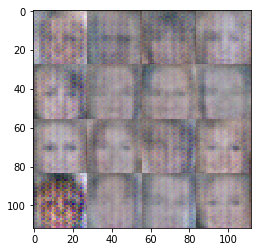

Epoch 1/1... Discriminator Loss: 0.4185... Generator Loss: 7.7773
Epoch 1/1... Discriminator Loss: 0.1743... Generator Loss: 2.3715
Epoch 1/1... Discriminator Loss: 0.1043... Generator Loss: 8.5035
Epoch 1/1... Discriminator Loss: 0.2407... Generator Loss: 1.8688
Epoch 1/1... Discriminator Loss: 0.1150... Generator Loss: 3.0317
Epoch 1/1... Discriminator Loss: 0.4827... Generator Loss: 1.2479
Epoch 1/1... Discriminator Loss: 0.0366... Generator Loss: 7.9525
Epoch 1/1... Discriminator Loss: 0.0156... Generator Loss: 6.4782
Epoch 1/1... Discriminator Loss: 1.3825... Generator Loss: 0.3654
Epoch 1/1... Discriminator Loss: 0.1378... Generator Loss: 15.3137


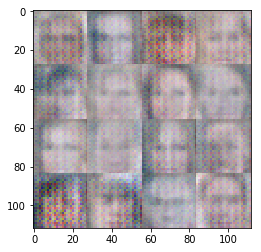

Epoch 1/1... Discriminator Loss: 0.0717... Generator Loss: 7.6562
Epoch 1/1... Discriminator Loss: 0.0225... Generator Loss: 5.2600
Epoch 1/1... Discriminator Loss: 0.0274... Generator Loss: 7.8093
Epoch 1/1... Discriminator Loss: 0.0082... Generator Loss: 10.4855
Epoch 1/1... Discriminator Loss: 0.0967... Generator Loss: 5.0862
Epoch 1/1... Discriminator Loss: 0.0628... Generator Loss: 9.4249
Epoch 1/1... Discriminator Loss: 0.0456... Generator Loss: 4.8989
Epoch 1/1... Discriminator Loss: 0.0283... Generator Loss: 7.2280
Epoch 1/1... Discriminator Loss: 0.3725... Generator Loss: 10.1447
Epoch 1/1... Discriminator Loss: 0.0157... Generator Loss: 10.6609


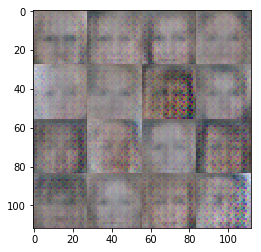

Epoch 1/1... Discriminator Loss: 0.4036... Generator Loss: 1.3998
Epoch 1/1... Discriminator Loss: 1.0449... Generator Loss: 11.5481
Epoch 1/1... Discriminator Loss: 0.0261... Generator Loss: 5.2845
Epoch 1/1... Discriminator Loss: 0.0322... Generator Loss: 9.6735
Epoch 1/1... Discriminator Loss: 0.0310... Generator Loss: 5.8095
Epoch 1/1... Discriminator Loss: 0.0203... Generator Loss: 7.5585
Epoch 1/1... Discriminator Loss: 0.5723... Generator Loss: 1.1239
Epoch 1/1... Discriminator Loss: 0.0183... Generator Loss: 6.2092
Epoch 1/1... Discriminator Loss: 0.2880... Generator Loss: 1.5782
Epoch 1/1... Discriminator Loss: 0.0217... Generator Loss: 7.0740


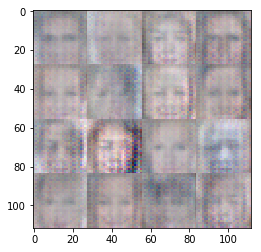

Epoch 1/1... Discriminator Loss: 1.1715... Generator Loss: 14.0690
Epoch 1/1... Discriminator Loss: 0.0330... Generator Loss: 14.4005
Epoch 1/1... Discriminator Loss: 0.0313... Generator Loss: 10.8047
Epoch 1/1... Discriminator Loss: 0.2934... Generator Loss: 14.1296
Epoch 1/1... Discriminator Loss: 0.1586... Generator Loss: 2.1812
Epoch 1/1... Discriminator Loss: 0.0218... Generator Loss: 4.8811
Epoch 1/1... Discriminator Loss: 0.0148... Generator Loss: 9.7369
Epoch 1/1... Discriminator Loss: 1.0916... Generator Loss: 6.5048
Epoch 1/1... Discriminator Loss: 0.1024... Generator Loss: 10.7346
Epoch 1/1... Discriminator Loss: 0.0187... Generator Loss: 11.6582


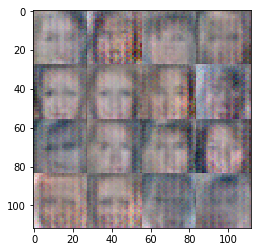

Epoch 1/1... Discriminator Loss: 0.0450... Generator Loss: 5.6971
Epoch 1/1... Discriminator Loss: 0.0189... Generator Loss: 13.2232
Epoch 1/1... Discriminator Loss: 0.0123... Generator Loss: 10.7208
Epoch 1/1... Discriminator Loss: 0.0083... Generator Loss: 10.1202
Epoch 1/1... Discriminator Loss: 0.0360... Generator Loss: 8.9539
Epoch 1/1... Discriminator Loss: 0.2380... Generator Loss: 1.7007
Epoch 1/1... Discriminator Loss: 0.0126... Generator Loss: 9.8374
Epoch 1/1... Discriminator Loss: 0.0182... Generator Loss: 5.6787
Epoch 1/1... Discriminator Loss: 0.0075... Generator Loss: 8.9324
Epoch 1/1... Discriminator Loss: 0.0171... Generator Loss: 6.3395


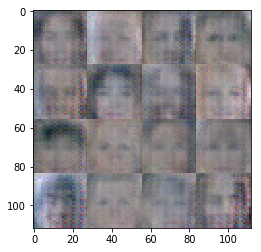

Epoch 1/1... Discriminator Loss: 0.4242... Generator Loss: 1.4319
Epoch 1/1... Discriminator Loss: 0.0071... Generator Loss: 12.5723
Epoch 1/1... Discriminator Loss: 0.2651... Generator Loss: 16.1299
Epoch 1/1... Discriminator Loss: 0.0036... Generator Loss: 9.6913
Epoch 1/1... Discriminator Loss: 0.0087... Generator Loss: 6.7639
Epoch 1/1... Discriminator Loss: 0.1083... Generator Loss: 2.8230
Epoch 1/1... Discriminator Loss: 0.1897... Generator Loss: 1.9484
Epoch 1/1... Discriminator Loss: 0.0121... Generator Loss: 8.7280
Epoch 1/1... Discriminator Loss: 0.0216... Generator Loss: 8.7031
Epoch 1/1... Discriminator Loss: 0.0421... Generator Loss: 3.7541


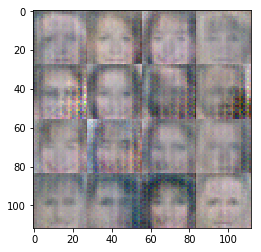

Epoch 1/1... Discriminator Loss: 0.0094... Generator Loss: 9.5388
Epoch 1/1... Discriminator Loss: 0.0127... Generator Loss: 9.0277
Epoch 1/1... Discriminator Loss: 0.0556... Generator Loss: 7.6847
Epoch 1/1... Discriminator Loss: 0.0305... Generator Loss: 8.7930
Epoch 1/1... Discriminator Loss: 0.0125... Generator Loss: 6.0405
Epoch 1/1... Discriminator Loss: 0.0111... Generator Loss: 9.6532
Epoch 1/1... Discriminator Loss: 0.0224... Generator Loss: 14.4714
Epoch 1/1... Discriminator Loss: 0.0300... Generator Loss: 4.3466
Epoch 1/1... Discriminator Loss: 0.0616... Generator Loss: 10.1232
Epoch 1/1... Discriminator Loss: 0.0085... Generator Loss: 10.5754


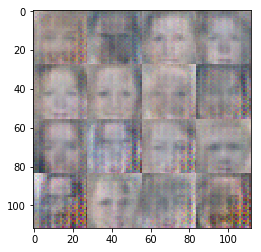

Epoch 1/1... Discriminator Loss: 0.0045... Generator Loss: 12.9392
Epoch 1/1... Discriminator Loss: 0.1314... Generator Loss: 2.6106
Epoch 1/1... Discriminator Loss: 0.0075... Generator Loss: 9.5725
Epoch 1/1... Discriminator Loss: 0.0067... Generator Loss: 8.4142
Epoch 1/1... Discriminator Loss: 0.0207... Generator Loss: 8.1834
Epoch 1/1... Discriminator Loss: 0.0463... Generator Loss: 4.8817
Epoch 1/1... Discriminator Loss: 0.0245... Generator Loss: 11.6239
Epoch 1/1... Discriminator Loss: 0.0133... Generator Loss: 6.1836


In [13]:
batch_size = 128
z_dim = 100
learning_rate = .0001
beta1 = .5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.